In [379]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

In [343]:
df = pd.read_csv("SeoulBikeData.csv")

df = df.rename(columns={
    "Date": "date",
    "Rented Bike Count": "demand",
    "Hour": 'hour',
    "Temperature(C)": "temperature",
    "Humidity(%)": "humidity",
    "Wind speed (m/s)": "wind_speed",
    "Visibility (10m)": "visibility",
    "Dew point temperature(C)": "dew_point_temperature",
    "Solar Radiation (MJ/m2)": "solar_radiation",
    "Rainfall(mm)": "rainfall",
    "Snowfall (cm)": "snowfall",
    "Seasons": "seasons",
    "Holiday": "holiday",
    "Functioning Day": "functioning_day"
})

df.date = pd.to_datetime( df.date, format="%d/%m/%Y")

df.head()

,date,demand,hour,temperature,humidity,wind_speed,visibility,dew_point_temperature,solar_radiation,rainfall,snowfall,seasons,holiday,functioning_day
0,2017-12-01,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,2017-12-01,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,2017-12-01,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,2017-12-01,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,2017-12-01,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


Vizualize data distributions

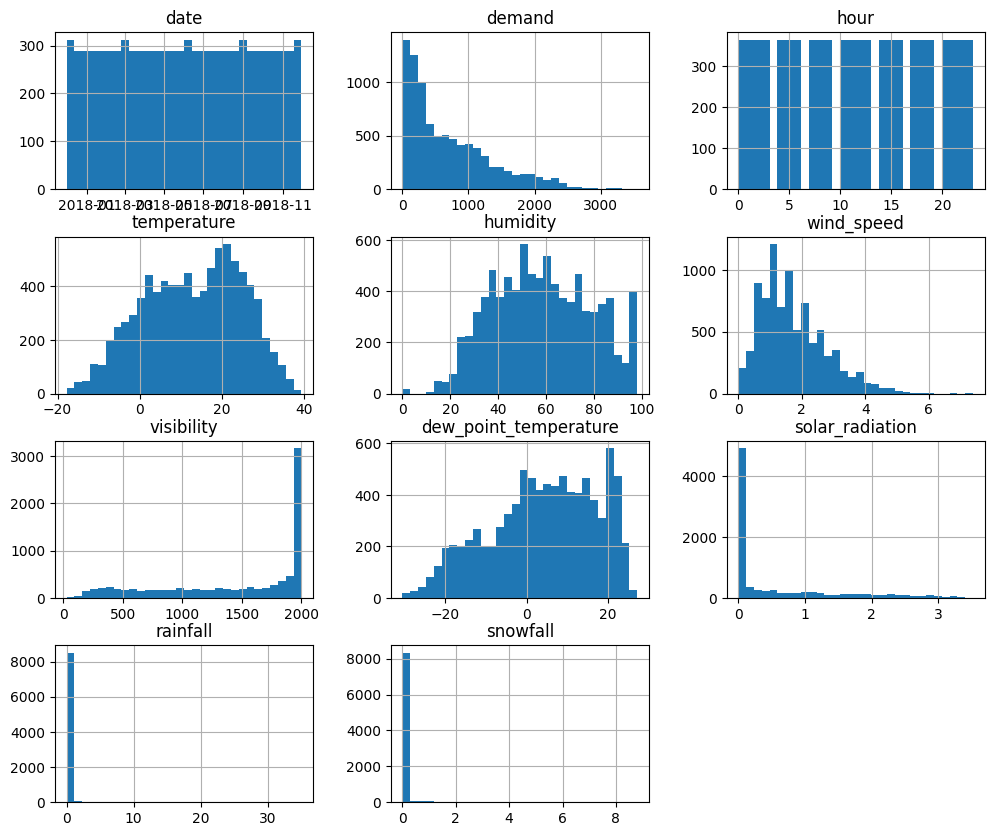

In [344]:
df.hist(bins=30, figsize=(12, 10))
plt.show()

### Train, Test split

### Insigths

In [345]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   date                   8760 non-null   datetime64[ns]
 1   demand                 8760 non-null   int64         
 2   hour                   8760 non-null   int64         
 3   temperature            8760 non-null   float64       
 4   humidity               8760 non-null   int64         
 5   wind_speed             8760 non-null   float64       
 6   visibility             8760 non-null   int64         
 7   dew_point_temperature  8760 non-null   float64       
 8   solar_radiation        8760 non-null   float64       
 9   rainfall               8760 non-null   float64       
 10  snowfall               8760 non-null   float64       
 11  seasons                8760 non-null   object        
 12  holiday                8760 non-null   object        
 13  fun

In [346]:
df.wind_speed.describe()

count    8760.000000
mean        1.724909
std         1.036300
min         0.000000
25%         0.900000
50%         1.500000
75%         2.300000
max         7.400000
Name: wind_speed, dtype: float64

In [347]:
df.select_dtypes(include=np.number).corr()['demand']

demand                   1.000000
hour                     0.410257
temperature              0.538558
humidity                -0.199780
wind_speed               0.121108
visibility               0.199280
dew_point_temperature    0.379788
solar_radiation          0.261837
rainfall                -0.123074
snowfall                -0.141804
Name: demand, dtype: float64

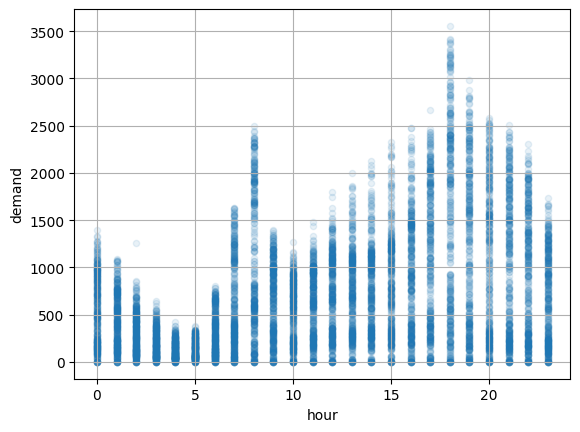

In [348]:
df.plot(kind='scatter', x='hour', y='demand', alpha=0.1, grid=True)
plt.show()

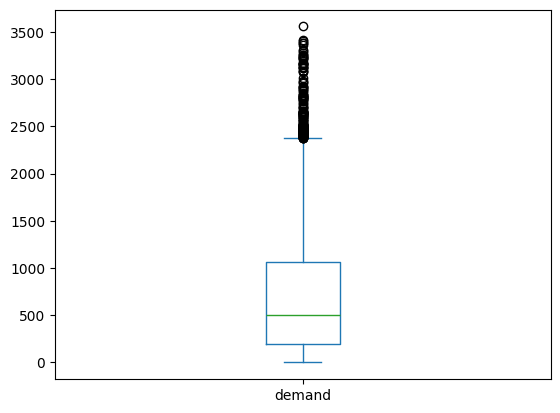

In [349]:
df.plot(kind="box", x="hour", y="demand")
plt.show()

### Train-test split

In [350]:
train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)

train_labels = train_set['demand']
train_set = train_set.drop(columns=['demand'])

test_labels = test_set['demand']
test_set = test_set.drop(columns=['demand'])

### Pipelines

In [365]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, FunctionTransformer, QuantileTransformer


def transform_date(df):
    df['date'] = (df['date'] - pd.to_datetime('2018-01-01')).apply(lambda x: x.days)
    return df


category_pipeline = make_pipeline(OneHotEncoder(handle_unknown="ignore"))
binary_category_pipeline = make_pipeline(OrdinalEncoder())

default_number_pipeline = make_pipeline(StandardScaler())
skewed_number_pipeline = make_pipeline(FunctionTransformer(np.sqrt, feature_names_out="one-to-one"), StandardScaler())
skewed_quantile_pipeline = make_pipeline(QuantileTransformer(output_distribution='normal', random_state=0))

date_pipeline = FunctionTransformer(transform_date, feature_names_out    ='one-to-one')

### Transform

In [378]:
from sklearn.compose import ColumnTransformer


preprocessing = ColumnTransformer([
    ("categorical", category_pipeline, ["seasons"]),
    ('date', date_pipeline, ['date']),
    ('number', default_number_pipeline, ['hour', 'temperature', 'humidity', 'visibility', 'solar_radiation', 'rainfall', 'snowfall', 'wind_speed']),
    ('drop', 'drop', ['holiday', 'functioning_day', 'dew_point_temperature']),
], remainder="passthrough")



### Final model

In [ ]:
from sklearn.ensemble import RandomForestRegressor


random_forest = make_pipeline(preprocessing, RandomForestRegressor(random_state=42))
random_forest.fit(train_set, train_labels)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['seasons']),
                                                 ('date',
                                                  FunctionTransformer(feature_names_out='one-to-one',
                                                                      func=<function transform_date at 0x7024d73b5c60>),
                                                  ['date']),
                                                 ('number',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  ['hour', 'temperature',
                                                   'humidity', 'visibility',
                                                   'solar_radiation',
                                                   'rainfall', 'snowfall',
                                                   'wind_speed']),
                                                 ('drop', 'drop',
                                                  ['holiday', 'functioning_day',
                                                   'dew_point_temperature'])])),
                ('randomforestregressor',
                 RandomForestRegressor(random_state=42))])

In [377]:
from sklearn.metrics import root_mean_squared_error


demand_predictions = random_forest.predict(train_set)

random_forest_rmse = root_mean_squared_error(demand_predictions, train_labels)

random_forest.score(test_set, test_labels)

0.827677164005227

### Test set evaluation

In [ ]:
demand_predictions = random_forest.predict(test_set)
random_forest_test_rmse = root_mean_squared_error(demand_predictions, test_labels)
random_forest.score(X)